In [1]:
# ===================================================
# CELLULE 1 : INSTALLATION DES DÉPENDANCES
# ===================================================
# Note : Si tout est déjà installé, vous pouvez passer cette cellule.

print("⏳ Installation des librairies principales...")
# On installe tout en une fois pour gagner du temps
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu122 --user
%pip install opencv-python pillow numpy matplotlib tqdm scikit-learn --user
%pip install transformers huggingface-hub peft accelerate pytorch-msssim --user

print("✅ Installation terminée. SI C'EST LA PREMIÈRE FOIS, REDÉMARREZ LE KERNEL (Menu Kernel > Restart).")

⏳ Installation des librairies principales...
Looking in indexes: https://download.pytorch.org/whl/cu122
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torchvision (from versions: none)
ERROR: No matching distribution found for torchvision

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\loicd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\loicd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
✅ Installation terminée. SI C'EST LA PREMIÈRE FOIS, REDÉMARREZ LE KERNEL (Menu Kernel > Restart).



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\loicd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from PIL import Image
import io
from pathlib import Path
import os
import torch
import matplotlib.pyplot as plt
import random
from peft import LoraConfig, get_peft_model, TaskType

C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
print("Import réussi !")

Import réussi !


In [4]:
def load_pretrained_model(model_name="depth-anything/Depth-Anything-V2-Small-hf"):
    """
    Charge le modèle Depth Anything V2 pré-entraîné et son processeur d'images
    """
    print(f" Chargement du modèle: {model_name}")

    image_processor = AutoImageProcessor.from_pretrained(model_name)
    base_model = AutoModelForDepthEstimation.from_pretrained(model_name)

    print(f"Modèle chargé avec succès")
    return base_model, image_processor

In [5]:
base_model, image_processor = load_pretrained_model()

 Chargement du modèle: depth-anything/Depth-Anything-V2-Small-hf


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Modèle chargé avec succès


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

In [7]:
# Count parameters
total_params = sum(p.numel() for p in base_model.parameters())
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 24,785,089
Trainable parameters: 24,785,089


In [8]:
# ===================================================
#NSPECTION DE L'ARCHITECTURE (VERSION NETTE)
# ===================================================
print("Inspection de l'architecture du modèle...")
print("="*60)

# On affiche juste les grands blocs pour comprendre la structure
print("STRUCTURE PRINCIPALE :")
seen_types = set()
for name, module in base_model.named_modules():
    # On affiche seulement le premier niveau de profondeur ou les blocs importants
    if name.count('.') <= 2: 
        print(f"  {name}: {module.__class__.__name__}")

print("\n" + "="*60)
print("COUCHES CIBLES POUR LORA (Attention & Dense) :")
# On cherche les couches qu'on va modifier
count = 0
for name, param in base_model.named_parameters():
    if "query" in name or "value" in name or "dense" in name:
        if count < 5: # On affiche juste les 5 premières pour l'exemple
            print(f"  {name}: {param.shape}")
        count += 1

print(f"\n... et {count - 5} autres couches similaires.")
print("="*60)

Inspection de l'architecture du modèle...
STRUCTURE PRINCIPALE :
  : DepthAnythingForDepthEstimation
  backbone: Dinov2Backbone
  backbone.embeddings: Dinov2Embeddings
  backbone.embeddings.patch_embeddings: Dinov2PatchEmbeddings
  backbone.embeddings.dropout: Dropout
  backbone.encoder: Dinov2Encoder
  backbone.encoder.layer: ModuleList
  backbone.layernorm: LayerNorm
  neck: DepthAnythingNeck
  neck.reassemble_stage: DepthAnythingReassembleStage
  neck.reassemble_stage.layers: ModuleList
  neck.convs: ModuleList
  neck.convs.0: Conv2d
  neck.convs.1: Conv2d
  neck.convs.2: Conv2d
  neck.convs.3: Conv2d
  neck.fusion_stage: DepthAnythingFeatureFusionStage
  neck.fusion_stage.layers: ModuleList
  head: DepthAnythingDepthEstimationHead
  head.conv1: Conv2d
  head.conv2: Conv2d
  head.activation1: ReLU
  head.conv3: Conv2d
  head.activation2: ReLU

COUCHES CIBLES POUR LORA (Attention & Dense) :
  backbone.encoder.layer.0.attention.attention.query.weight: torch.Size([384, 384])
  backbone

Preparation de données 

In [12]:

path_images = r"C:\Users\loicd\Desktop\DATASET_DEVOIR\DATASET_DEVOIR\images"
path_depths = r"C:\Users\loicd\Desktop\DATASET_DEVOIR\DATASET_DEVOIR\depth"

In [13]:
print(f"📂 Dossier Images visé : {path_images}")
print(f"📂 Dossier Depth visé  : {path_depths}")

# Vérification que les dossiers existent
if os.path.exists(path_images) and os.path.exists(path_depths):
    print("\n✅ Les dossiers existent !")
    
    # Compter les fichiers pour être sûr
    nb_img = len([f for f in os.listdir(path_images) if f.endswith(('.png', '.jpg'))])
    nb_npy = len([f for f in os.listdir(path_depths) if f.endswith('.npy')])
    
    print(f"   -> Trouvé {nb_img} images")
    print(f"   -> Trouvé {nb_npy} fichiers XYZ (.npy)")
else:
    print("\n❌ ERREUR : Un des chemins est introuvable.")
    print("   Vérifie l'orthographe ou copie le chemin absolu.")

📂 Dossier Images visé : C:\Users\loicd\Desktop\DATASET_DEVOIR\DATASET_DEVOIR\images
📂 Dossier Depth visé  : C:\Users\loicd\Desktop\DATASET_DEVOIR\DATASET_DEVOIR\depth

✅ Les dossiers existent !
   -> Trouvé 58 images
   -> Trouvé 58 fichiers XYZ (.npy)


In [14]:
# 2. COMPTAGE ET LISTING
# ==========================================
print("Démarrage de la vérification...")

# On liste et on trie pour garantir l'ordre
# On ne garde que les fichiers (pas les dossiers cachés)
files_img = sorted([f for f in os.listdir(path_images) if f.endswith(('.png', '.jpg'))])
files_npy = sorted([f for f in os.listdir(path_depths) if f.endswith('.npy')])

num_img = len(files_img)
num_npy = len(files_npy)

print(f"Bilan:")
print(f"   - Images (.png/.jpg) : {num_img}")
print(f"   - Depths (.npy)      : {num_npy}")

Démarrage de la vérification...
Bilan:
   - Images (.png/.jpg) : 58
   - Depths (.npy)      : 58


In [15]:
# Analyse des données image par image
print(f"Analyse de {len(files_npy)} fichiers .npy pixel par pixel...")

# Initialisation des compteurs globaux
total_nan_global = 0
total_zero_global = 0
total_inf_global = 0
total_pixels_analyses = 0

rapport_erreurs = {}

for filename in files_npy:
    full_path = os.path.join(path_depths, filename)
    
    try:
        data = np.load(full_path)
        total_pixels_analyses += data.size
        
        # Détection par type
        num_nan = np.count_nonzero(np.isnan(data))
        num_zero = np.count_nonzero(data == 0)
        num_inf = np.count_nonzero(np.isinf(data))
        
        # Somme des manquants pour ce fichier précis
        total_manquants_file = num_nan + num_zero + num_inf

        # Mise à jour des compteurs globaux
        total_nan_global += num_nan
        total_zero_global += num_zero
        total_inf_global += num_inf

        if total_manquants_file > 0:
            # On stocke les détails pour le rapport final
            rapport_erreurs[filename] = {
                "nan": num_nan, 
                "zero": num_zero, 
                "inf": num_inf, 
                "total": total_manquants_file,
                "shape": data.shape
            }
            # Affichage immédiat pour suivre l'avancement
            print(f"⚠️ {filename} : {total_manquants_file} valeurs manquantes détectées")

    except Exception as e:
        print(f"❌ Erreur lecture {filename}: {e}")

# --- Résumé final détaillé ---
print("\n" + "="*50)
print("📊 BILAN DÉTAILLÉ PAR IMAGE")
print("="*50)

if not rapport_erreurs:
    print("✨ Félicitations ! Aucun pixel manquant sur l'ensemble du dataset.")
else:
    # On trie les erreurs pour afficher les fichiers les plus problématiques en premier
    fichiers_tries = sorted(rapport_erreurs.items(), key=lambda x: x[1]['total'], reverse=True)
    
    for filename, stats in fichiers_tries:
        print(f"🖼️  {filename :<25} | Total manquants: {stats['total']:<8} (NaN:{stats['nan']}, 0:{stats['zero']})")

    print("\n" + "="*50)
    print("📈 STATISTIQUES GLOBALES")
    print("-" * 50)
    total_anomalies = total_nan_global + total_zero_global + total_inf_global
    print(f"✅ Total pixels analysés : {total_pixels_analyses:,}")
    print(f"❌ Total valeurs manquantes : {total_anomalies:,}")
    
    if total_pixels_analyses > 0:
        pourcentage = (total_anomalies / total_pixels_analyses) * 100
        print(f"⚠️ Taux de corruption global : {pourcentage:.4f}%")
    print(f"📂 Nombre de fichiers affectés : {len(rapport_erreurs)} / {len(files_npy)}")

Analyse de 58 fichiers .npy pixel par pixel...
⚠️ 21-12-03-18-50-31_Zivid_acquisition_rawDepth.npy : 2116980 valeurs manquantes détectées
⚠️ 21-12-03-18-50-34_Zivid_acquisition_rawDepth.npy : 1730646 valeurs manquantes détectées
⚠️ 21-12-03-18-50-37_Zivid_acquisition_rawDepth.npy : 1655943 valeurs manquantes détectées
⚠️ 21-12-03-18-50-39_Zivid_acquisition_rawDepth.npy : 2033433 valeurs manquantes détectées
⚠️ 21-12-03-18-50-55_Zivid_acquisition_rawDepth.npy : 2366760 valeurs manquantes détectées
⚠️ 21-12-03-18-52-27_Zivid_acquisition_rawDepth.npy : 1982451 valeurs manquantes détectées
⚠️ 21-12-03-18-52-30_Zivid_acquisition_rawDepth.npy : 1700013 valeurs manquantes détectées
⚠️ 21-12-03-18-52-32_Zivid_acquisition_rawDepth.npy : 2108175 valeurs manquantes détectées
⚠️ 21-12-03-18-52-35_Zivid_acquisition_rawDepth.npy : 1727091 valeurs manquantes détectées
⚠️ 21-12-03-18-52-37_Zivid_acquisition_rawDepth.npy : 1658802 valeurs manquantes détectées
⚠️ 21-12-03-18-52-40_Zivid_acquisition_rawD

### Gestion des valeurs manquantes
Pourquoi ne pas utiliser l'Inpainting ou l'Interpolation ?
Bien que l'inpainting (rebouchage) soit courant en vision par ordinateur classique, il comporte un risque majeur pour notre projet industriel : inventer de la matière. Sur un pneu, une rayure ou un défaut de gomme peut ressembler à une "donnée manquante". Si nous rebouchons artificiellement ces zones, le modèle apprendra à lisser les défauts au lieu de les détecter.

Notre Stratégie : Le Masquage Dynamique (Valid Mask)
Plutôt que de modifier les données brutes (ce qui introduirait du bruit), nous avons opté pour une approche "Data-Centric" rigoureuse intégrée directement dans la fonction de perte (Loss Function) :

Identification : Lors du chargement, nous créons un masque binaire (valid_mask) où 1 = pixel valide et 0 = pixel manquant (NaN, Inf, ou 0 venant du capteur).

Entraînement Sélectif : Dans notre boucle d'entraînement, la perte (Loss) n'est calculée que sur les pixels où le masque vaut 1.

Conséquence : Le modèle est libre de prédire ce qu'il "pense" être correct dans les zones vides, mais il n'est jamais pénalisé s'il se trompe sur ces zones invisibles.

Résultat : Cela permet au modèle d'apprendre la structure globale du pneu grâce aux pixels valides, sans être pollué par les artefacts du capteur.

In [16]:
# ==========================================
# 3. VÉRIFICATION DE L'ALIGNEMENT
# ==========================================
if num_img != num_npy:
    print(f"ATTENTION : Le nombre de fichiers ne correspond pas ! (Différence : {abs(num_img - num_npy)})")
else:
    print("Le nombre de fichiers est identique.")

# Vérification des correspondances de noms (optionnel mais recommandé)
# On vérifie si image_01_color.png a bien son équivalent image_01_rawDepth.npy
mismatches = []
for img_name in files_img:
    # On recrée le nom attendu du fichier depth (selon la logique Zivid vue dans ton notebook)
    # Ex: "scan_color.png" -> "scan_rawDepth.npy"
    expected_depth_name = img_name.replace("_color.png", "_rawDepth.npy").replace(".png", ".npy")
    
    # Si tes fichiers n'ont pas "_color", ajuste cette ligne (ex: replace(".png", ".npy"))
    
    if expected_depth_name not in files_npy:
        mismatches.append((img_name, expected_depth_name))

if len(mismatches) > 0:
    print(f"ATTENTION : {len(mismatches)} paires ne correspondent pas au niveau du nom !")
    print(f"   Exemple de manquant : {mismatches[0]}")
else:
    print("Tous les noms de fichiers semblent correspondre (logique color <-> rawDepth).")

Le nombre de fichiers est identique.
Tous les noms de fichiers semblent correspondre (logique color <-> rawDepth).


In [17]:
# ==========================================
# 4. TEST D'EXTRACTION DU Z 
# ==========================================

if num_npy > 0:
    print("\n Test d'extraction du canal Z sur un fichier aléatoire...")
    
    # Prendre un fichier au hasard
    random_npy = random.choice(files_npy)
    full_path = os.path.join(path_depths, random_npy)
    
    try:
        # Chargement
        data = np.load(full_path) # Shape (H, W, 3) normalement
        
        print(f"   Fichier : {random_npy}")
        print(f"   Shape originale : {data.shape}")
        
        if len(data.shape) == 3 and data.shape[2] == 3:
            # EXTRACTION DU Z (Canal index 2)
            Z_channel = data[:, :, 2]
            
            # Vérif statistiques
            print(f"   Extraction Z réussie ! Shape finale : {Z_channel.shape}")
            print(f"   Val Min (avec NaN) : {np.nanmin(Z_channel)}")
            print(f"   Val Max (avec NaN) : {np.nanmax(Z_channel)}")
            
            # Vérification des NaN
            nan_count = np.isnan(Z_channel).sum()
            print(f"   Nombre de pixels NaN (vides) : {nan_count} ({(nan_count/Z_channel.size)*100:.1f}%)")
        else:
            print("Erreur : Le fichier .npy n'a pas 3 canaux (XYZ). Vérifie le format.")
            
    except Exception as e:
        print(f"Erreur lors du chargement : {e}")


 Test d'extraction du canal Z sur un fichier aléatoire...
   Fichier : 22-09-22-14-37-04_Zivid_acquisition_rawDepth.npy
   Shape originale : (1200, 1944, 3)
   Extraction Z réussie ! Shape finale : (1200, 1944)
   Val Min (avec NaN) : 256.7230529785156
   Val Max (avec NaN) : 3172.142333984375
   Nombre de pixels NaN (vides) : 990497 (42.5%)


In [18]:
filename = "21-12-03-19-05-46_Zivid_acquisition_rawDepth.npy"
full_path = os.path.join(path_depths, filename)

# --- EXTRACTION ---
# 1. Chargement de la donnée (1200, 1944, 3)
data_xyz = np.load(full_path)

# 2. Extraction de la carte de profondeur Z (1200, 1944)
Z_channel = data_xyz[:, :, 2] 

# 3. Traitement des NaN (pour s'assurer qu'on peut lire)
Z_clean = np.nan_to_num(Z_channel, nan=0.0)

# --- LECTURE DE LA VALEUR D'UN PIXEL ---
pixel_row = 600
pixel_col = 972

# Accéder à la valeur Z du pixel (600, 972)
profondeur_pixel = Z_clean[pixel_row, pixel_col]

print(f"Le fichier chargé est de forme : {Z_channel.shape}")
print(f"La valeur de Profondeur (Z) au pixel [{pixel_row}, {pixel_col}] est :")
print(f"-> **{profondeur_pixel:.2f} mm**")

Le fichier chargé est de forme : (1200, 1944)
La valeur de Profondeur (Z) au pixel [600, 972] est :
-> **1365.02 mm**


### Pourquoi traiter les données à la volée (`__getitem__`) ?

Nous avons choisi d'extraire le canal Z et de normaliser les données directement dans la classe `Dataset` (pendant l'entraînement) plutôt que de créer une copie "propre" du dataset sur le disque. Ce choix technique est motivé par trois facteurs :

#### 1. Économie de Stockage (Zivid = Lourd)
Chaque fichier `.npy` original contient 3 canaux (X, Y, Z). Si nous avions pré-traité tout le dataset pour sauvegarder uniquement le canal Z, nous aurions dû dupliquer des milliers de fichiers, doublant l'espace disque nécessaire.
* **Approche choisie :** Le fichier XYZ est chargé en RAM, le canal Z est extrait, et le reste est libéré immédiatement. Zéro duplication.

#### 2. Flexibilité de la Résolution (Approche Data-Centric)
C'est l'avantage majeur. En effectuant le redimensionnement dans `__getitem__`, nous pouvons tester différentes résolutions (518x518, puis 756x1260) simplement en changeant un paramètre de configuration.
* Si nous avions figé le dataset en amont, il aurait fallu tout recalculer pour chaque test de résolution.

#### 3. Gestion Dynamique des Masques
Au lieu de "boucher les trous" définitivement en remplaçant les NaN par 0 dans un fichier, nous générons un **masque de validité** à la volée. Cela permet au modèle d'ignorer mathématiquement les zones vides, sans altérer la donnée source.

Configuration de LoRA


In [19]:
# --- 3. DÉFINITION DE LA CONFIGURATION LoRA ---

# Pour les Vision Transformers, nous ciblons les couches d'attention (Query, Key, Value)
lora_config = LoraConfig(
    r=16,                                    # Le rang de la matrice LoRA (ajustement de la capacité d'apprentissage)
    lora_alpha=32,                           # Facteur de mise à l'échelle (généralement 2 * r)
    target_modules=["query", "key", "value"],# Les couches spécifiques du ViT à modifier (Attention)
    lora_dropout=0.05,                       # Dropout appliqué aux couches LoRA
    bias="none",                             # Ne pas adapter les biais
)

In [20]:
# La fonction get_peft_model gèle les poids du modèle de base et ajoute les adaptateurs LoRA
model_lora = get_peft_model(base_model, lora_config)

print("✅Modèle LoRA appliqué !")
# Afficher le nombre de paramètres entraînés
model_lora.print_trainable_parameters()

✅Modèle LoRA appliqué !
trainable params: 442,368 || all params: 25,227,457 || trainable%: 1.7535


In [21]:
def depth_data_collator(features):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in features]),
        "labels": torch.stack([x["labels"] for x in features]), # Changé depth_gt -> labels
        "valid_mask": torch.stack([x["valid_mask"] for x in features]),
    }

In [22]:
# ===================================================
# CALCUL DES STATISTIQUES GLOBALES DU DATASET
# ===================================================
print(" Calcul des statistiques sur TOUS les fichiers depth...")
print("   (Cela peut prendre quelques minutes...)\n")

depth_stats = {
    'min_values': [],
    'max_values': [],
    'mean_values': [],
    'valid_percentages': []
}

# Parcourir TOUS les fichiers .npy
from tqdm import tqdm  # Pour une barre de progression

for depth_file in tqdm(files_npy, desc="Analyse des fichiers depth"):
    depth_path = os.path.join(path_depths, depth_file)
    
    # Charger et extraire Z
    depth_xyz = np.load(depth_path)
    depth_z = depth_xyz[:, :, 2]
    
    # Calculer statistiques (en ignorant NaN)
    if not np.all(np.isnan(depth_z)):  # Si au moins une valeur valide
        depth_stats['min_values'].append(np.nanmin(depth_z))
        depth_stats['max_values'].append(np.nanmax(depth_z))
        depth_stats['mean_values'].append(np.nanmean(depth_z))
        
        # % de pixels valides
        valid_pct = (~np.isnan(depth_z)).sum() / depth_z.size * 100
        depth_stats['valid_percentages'].append(valid_pct)

# Calculer les statistiques globales
GLOBAL_MIN = np.min(depth_stats['min_values'])
GLOBAL_MAX = np.max(depth_stats['max_values'])
GLOBAL_MEAN = np.mean(depth_stats['mean_values'])
GLOBAL_STD = np.std(depth_stats['mean_values'])

print("\n" + "="*60)
print("STATISTIQUES GLOBALES DU DATASET")
print("="*60)
print(f" Profondeur MIN (sur tous les fichiers): {GLOBAL_MIN:.2f} mm")
print(f" Profondeur MAX (sur tous les fichiers): {GLOBAL_MAX:.2f} mm")
print(f" Moyenne des moyennes: {GLOBAL_MEAN:.2f} mm")
print(f" Écart-type: {GLOBAL_STD:.2f} mm")
print(f" Pixels valides (moyenne): {np.mean(depth_stats['valid_percentages']):.1f}%")
print("="*60)

# Ces valeurs vont servir pour la normalisation!
print(f"\n Utilisez ces valeurs dans votre Dataset:")
print(f"   depth_min = {GLOBAL_MIN:.2f}")
print(f"   depth_max = {GLOBAL_MAX:.2f}")

 Calcul des statistiques sur TOUS les fichiers depth...
   (Cela peut prendre quelques minutes...)



Analyse des fichiers depth: 100%|██████████| 58/58 [00:01<00:00, 31.09it/s]


STATISTIQUES GLOBALES DU DATASET
 Profondeur MIN (sur tous les fichiers): 251.74 mm
 Profondeur MAX (sur tous les fichiers): 3907.45 mm
 Moyenne des moyennes: 1542.16 mm
 Écart-type: 295.35 mm
 Pixels valides (moyenne): 68.5%

 Utilisez ces valeurs dans votre Dataset:
   depth_min = 251.74
   depth_max = 3907.45


In [23]:
# ===================================================
# SPLIT TRAIN / VALIDATION
# ===================================================
from sklearn.model_selection import train_test_split

# Vos fichiers déjà triés
files_img = sorted([f for f in os.listdir(path_images) if f.endswith('.png')])
files_npy = sorted([f for f in os.listdir(path_depths) if f.endswith('.npy')])

print(f" Total de fichiers: {len(files_img)}")

# Split 80% train, 20% validation
train_imgs, val_imgs, train_depths, val_depths = train_test_split(
    files_img, files_npy, 
    test_size=0.2,  # 20% validation
    random_state=42,  # Pour reproductibilité
    shuffle=True
)

print(f" Split effectué:")
print(f"   Train: {len(train_imgs)} échantillons")
print(f"   Val:   {len(val_imgs)} échantillons")

 Total de fichiers: 58
 Split effectué:
   Train: 46 échantillons
   Val:   12 échantillons


In [24]:
from torch.utils.data import Dataset
class ZividDepthDataset(Dataset):
    def __init__(self, image_folder, depth_folder, image_files, depth_files, processor, depth_min, depth_max, use_inverse=True):
        self.image_folder = image_folder
        self.depth_folder = depth_folder
        self.image_files = image_files
        self.depth_files = depth_files
        self.processor = processor
        self.depth_min = depth_min
        self.depth_max = depth_max
        self.use_inverse = use_inverse

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        
        depth_path = os.path.join(self.depth_folder, self.depth_files[idx])
        depth_map = np.load(depth_path)
        
        # Correction Canal Z (Profondeur)
        if depth_map.ndim == 3:
            depth_map = depth_map[:, :, 2]
        
        # Masque avant normalisation
        valid_mask = (depth_map > 0) & (depth_map < 10000) & (~np.isnan(depth_map))
        depth_map = np.nan_to_num(depth_map, nan=0.0)

        # Normalisation
        if self.use_inverse:
            depth_inv = 1.0 / (depth_map + 1e-6)
            depth_min_inv = 1.0 / self.depth_max
            depth_max_inv = 1.0 / self.depth_min
            depth_normalized = (depth_inv - depth_min_inv) / (depth_max_inv - depth_min_inv + 1e-6)
        else:
            depth_normalized = (depth_map - self.depth_min) / (self.depth_max - self.depth_min + 1e-6)
        
        depth_normalized = np.clip(depth_normalized, 0.0, 1.0)
        
        # 🔥 HAUTE RÉSOLUTION : On impose 756x1260 (multiple de 14)
        inputs = self.processor(images=image, return_tensors="pt", size={"height": 756, "width": 1260})
        pixel_values = inputs.pixel_values.squeeze(0)
        
        return {
            "pixel_values": pixel_values,
            "labels": torch.from_numpy(depth_normalized).float(),
            "valid_mask": torch.from_numpy(valid_mask).float()
        }

In [25]:
from transformers import Trainer
import torch.nn.functional as F
import torch
class DepthTrainerFinal(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        pixel_values = inputs["pixel_values"]
        labels = inputs["labels"]
        mask = inputs.get("valid_mask", None)
        
        # Inférence
        outputs = model(pixel_values=pixel_values)
        pred = outputs.predicted_depth
        
        # 1. Mise à l'échelle (Bicubic pour préserver les courbes des pneus)
        # On passe de la résolution interne (ex: 756x1260) à la résolution du label (1200x1944)
        pred = F.interpolate(
            pred.unsqueeze(1), 
            size=labels.shape[-2:], 
            mode="bicubic", 
            align_corners=False
        ).squeeze(1)
        
        # 2. Masquage des zones valides (évite d'apprendre sur les NaN/vides)
        valid_mask = (mask > 0) & (labels > 0)
        
        # 3. Perte L1 (Précision globale de la distance)
        l1_loss = F.l1_loss(pred[valid_mask], labels[valid_mask])
        
        # 4. Perte de Gradient (Netteté des contours)
        def get_grad(x):
            # Calcule la différence entre pixels adjacents
            dx = x[:, :, 1:] - x[:, :, :-1]
            dy = x[:, 1:, :] - x[:, :-1, :]
            return dx, dy

        pdx, pdy = get_grad(pred)
        gdx, gdy = get_grad(labels)
        
        # Masques pour les gradients (les deux pixels voisins doivent être valides)
        mask_x = valid_mask[:, :, 1:] * valid_mask[:, :, :-1]
        mask_y = valid_mask[:, 1:, :] * valid_mask[:, :-1, :]

        # Poids : On multiplie par 10 l'importance des pixels qui sont des bords (fort gradient)
        weight_x = 1.0 + 10.0 * (torch.abs(gdx) > 0.02).float() 
        weight_y = 1.0 + 10.0 * (torch.abs(gdy) > 0.02).float()
        
        # Somme des erreurs de gradient normalisée par le nombre de pixels valides
        grad_loss_x = (torch.abs(pdx - gdx) * weight_x * mask_x).sum() / (mask_x.sum() + 1e-6)
        grad_loss_y = (torch.abs(pdy - gdy) * weight_y * mask_y).sum() / (mask_y.sum() + 1e-6)
        
        grad_loss = grad_loss_x + grad_loss_y
        
        # 5. PERTE TOTALE pondérée
        loss = l1_loss + 3.0 * grad_loss
        
        # Retour indispensable pour le Trainer de HuggingFace
        return (loss, outputs) if return_outputs else loss

In [26]:
# ===================================================
# CELLULE DE SAUVETAGE : INSTANCIATION & TRAINER
# ===================================================
from transformers import TrainingArguments
import torch

# 1. On recrée les Datasets pour être SÛR qu'ils existent et sont bien configurés
# Important : use_inverse=False pour la métrologie (mesure précise en mm)
print("🔨 Création des Datasets (Mode Linéaire pour Pneus)...")
train_dataset = ZividDepthDataset(
    image_folder=path_images,
    depth_folder=path_depths,
    image_files=train_imgs,
    depth_files=train_depths,
    processor=image_processor,
    depth_min=GLOBAL_MIN,
    depth_max=GLOBAL_MAX,
    use_inverse=False 
)

val_dataset = ZividDepthDataset(
    image_folder=path_images,
    depth_folder=path_depths,
    image_files=val_imgs,
    depth_files=val_depths,
    processor=image_processor,
    depth_min=GLOBAL_MIN,
    depth_max=GLOBAL_MAX,
    use_inverse=False
)

# 2. Nettoyage VRAM
torch.cuda.empty_cache()

# 3. Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./resultats_pneu_v5",
    learning_rate=5e-5,
    num_train_epochs=15,
    per_device_train_batch_size=1,      # Indispensable pour la haute résolution
    gradient_accumulation_steps=8,      # Simule un batch de 8
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
    remove_unused_columns=False,
    dataloader_num_workers=0,
    report_to="none"
)

# 4. Initialisation du Trainer
trainer = DepthTrainerFinal(
    model=model_lora,                   # On utilise bien 'model_lora'
    args=training_args,
    train_dataset=train_dataset,        # On utilise les variables créées juste au-dessus
    eval_dataset=val_dataset,
    data_collator=depth_data_collator,
)



🔨 Création des Datasets (Mode Linéaire pour Pneus)...


In [27]:
# 5. Lancement !
print("\n" + "="*40)
print("🚀 DÉMARRAGE IMMÉDIAT")
print("="*40)
trainer.train()

# 6. Sauvegarde
model_lora.save_pretrained("./final_model_pneu_expert")
image_processor.save_pretrained("./final_model_pneu_expert")
print("✅ Modèle sauvegardé avec succès !")


🚀 DÉMARRAGE IMMÉDIAT


C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,1.317092
2,No log,0.748281
3,No log,0.408907
4,No log,0.326149
5,No log,0.290210
6,No log,0.240920
7,No log,0.205542
8,No log,0.174637
9,No log,0.158163
10,No log,0.136521


C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\loicd\AppData\Local\Packages

✅ Modèle sauvegardé avec succès !


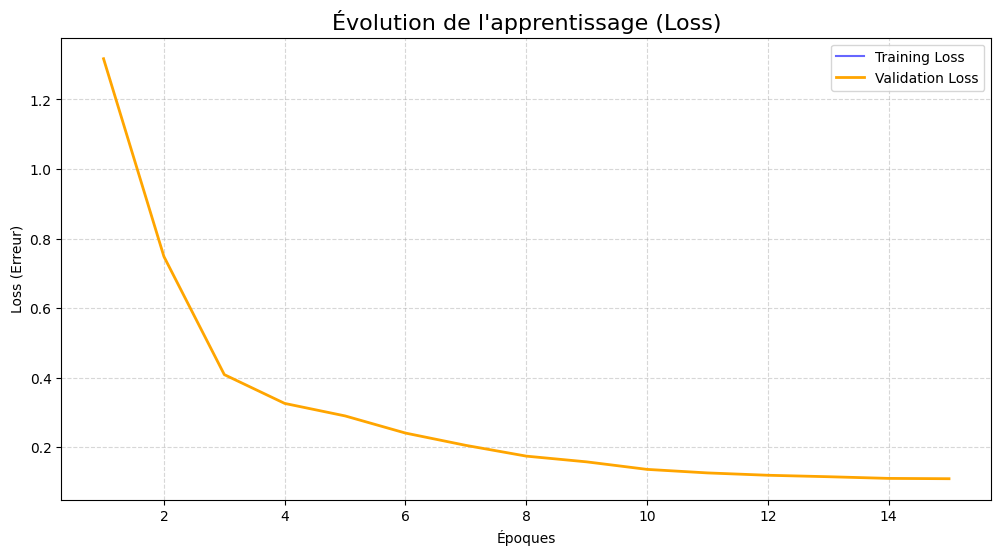

✅ Si la courbe orange descend et se stabilise, c'est gagné !


In [28]:
# ===================================================
# 📊 VISUALISATION DES COURBES DE LOSS
# ===================================================
import matplotlib.pyplot as plt

# Récupération de l'historique
history = trainer.state.log_history

# Extraction des données
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
epochs_train = [x['epoch'] for x in history if 'loss' in x]
epochs_eval = [x['epoch'] for x in history if 'eval_loss' in x]

# Tracé
plt.figure(figsize=(12, 6))
plt.plot(epochs_train, train_loss, label='Training Loss', color='blue', alpha=0.6)
if len(eval_loss) > 0:
    plt.plot(epochs_eval, eval_loss, label='Validation Loss', color='orange', linewidth=2)

plt.title("Évolution de l'apprentissage (Loss)", fontsize=16)
plt.xlabel("Époques")
plt.ylabel("Loss (Erreur)")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

print("✅ Si la courbe orange descend et se stabilise, c'est gagné !")

C:\Users\loicd\AppData\Local\Temp\ipykernel_19500\1017025247.py:55: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\loicd\AppData\Local\Temp\ipykernel_19500\1017025247.py:55: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\loicd\AppData\Local\Temp\ipykernel_19500\1017025247.py:55: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (

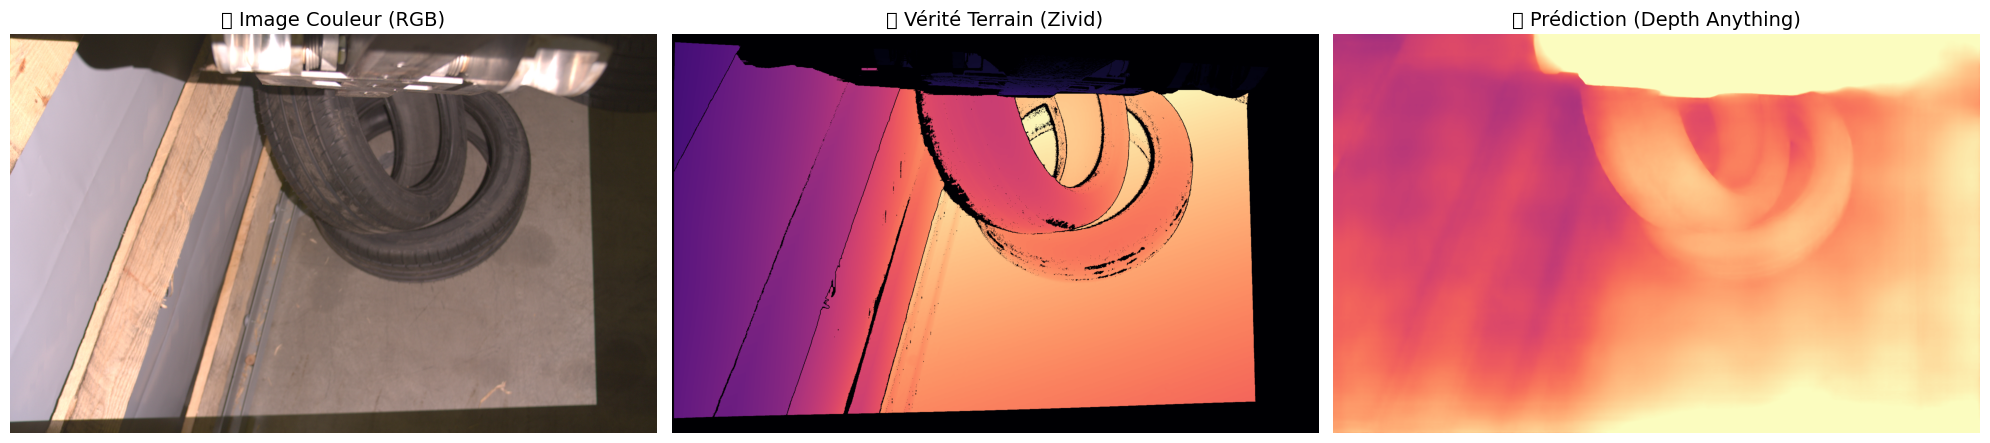

✅ Visualisation de l'échantillon n°10
👉 Regarde bien les rainures du pneu sur la 3ème image !


In [29]:
# ===================================================
# 👁️ RÉSULTAT VISUEL FINAL (RGB vs GT vs PRED)
# ===================================================
import random
import torch.nn.functional as F

# 1. Sélectionner une image aléatoire dans la Validation
idx = random.randint(0, len(val_dataset) - 1)
sample = val_dataset[idx]

# Préparation des données
pixel_values = sample["pixel_values"].unsqueeze(0).to(model_lora.device) # Ajout dimension batch
label = sample["labels"].cpu().numpy()

# 2. Inférence (Prédiction)
model_lora.eval() # Mode évaluation
with torch.no_grad():
    outputs = model_lora(pixel_values=pixel_values)
    pred_raw = outputs.predicted_depth

    # Remise à l'échelle (Interpolation vers la taille de l'étiquette)
    # Le modèle sort du 756x1260, on s'assure que ça matche le label
    pred_interpolated = F.interpolate(
        pred_raw.unsqueeze(1), 
        size=label.shape, 
        mode="bicubic", 
        align_corners=False
    ).squeeze().cpu().numpy()

# 3. Affichage Comparatif
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Image RGB (On doit dénormaliser pour l'affichage si le processor a normalisé, 
# mais ici on affiche l'image brute via le dataset ou on laisse matplotlib gérer)
# Pour faire simple, on réouvre l'image originale pour un affichage propre
original_img_path = os.path.join(path_images, val_dataset.image_files[idx])
original_img = Image.open(original_img_path)

axs[0].imshow(original_img)
axs[0].set_title("📸 Image Couleur (RGB)", fontsize=14)
axs[0].axis("off")

# Vérité Terrain (Ground Truth)
# On utilise 'magma' car c'est excellent pour la profondeur (Noir=Loin, Clair=Proche)
d_min, d_max = label.min(), label.max()
axs[1].imshow(label, cmap='magma', vmin=d_min, vmax=d_max)
axs[1].set_title("🎯 Vérité Terrain (Zivid)", fontsize=14)
axs[1].axis("off")

# Prédiction du Modèle
axs[2].imshow(pred_interpolated, cmap='magma', vmin=d_min, vmax=d_max)
axs[2].set_title("🤖 Prédiction (Depth Anything)", fontsize=14)
axs[2].axis("off")

plt.tight_layout()
plt.show()

print(f"✅ Visualisation de l'échantillon n°{idx}")
print("👉 Regarde bien les rainures du pneu sur la 3ème image !")